# Image Classification with ResNet18 on Apple M4 GPU

This notebook implements an image classification model using transfer learning with ResNet18, optimized for Apple Silicon (M4) GPU acceleration.

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import time
import os
import platform
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
import multiprocessing

## 1. M4 Hardware Acceleration Configuration

In [32]:
# Configuration settings
CONFIG = {
    'train_data_dir': '../Public_dataset',  # Full path to training data
    'test_data_dir': '../Public_dataset',   # Using same dataset; DataLoader will split into train/val
    'batch_size': 64,
    'num_epochs': 10,
    'learning_rate': 0.001,
    'num_classes': 3,  # Adjust based on your classes (aluminium, paper, plastic)
    'early_stop_patience': 5,
    'train_val_split': 0.8,  # 80% train, 20% val
}

# 自动检测 Apple Silicon (MPS)
if torch.backends.mps.is_available():
    CONFIG['device'] = torch.device("mps")
    print(f"🚀 Success! Using Apple M4 GPU (MPS) acceleration.")
else:
    CONFIG['device'] = torch.device("cpu")
    print("⚠️ Warning: MPS not available. Using CPU (Slower).")

⚠️ Warning: MPS not available. Using CPU (Slower).


## 2. Data Preprocessing and Loading

In [33]:
# import os
# import shutil
# import random
# from pathlib import Path

# # =================配置区域=================
# # 你的原始解压路径
# SOURCE_DIR = './' 

# # 你的目标路径 (ResNet 代码要读取的路径)
# TARGET_DIR = './Dataset_Assigned' 

# # 验证集比例 (20%)
# VAL_RATIO = 0.2
# # =========================================

# def reorganize_dataset():
#     if not os.path.exists(SOURCE_DIR):
#         print(f"❌ Error: Source directory '{SOURCE_DIR}' not found!")
#         return

#     print(f"🚀 Starting dataset reorganization...")
#     print(f"   From: {SOURCE_DIR}")
#     print(f"   To:   {TARGET_DIR}")

#     # 获取所有类别 (排除 json 文件和隐藏文件)
#     classes = [d for d in os.listdir(SOURCE_DIR) 
#                if os.path.isdir(os.path.join(SOURCE_DIR, d)) and not d.startswith('.')]
    
#     print(f"   Found {len(classes)} classes: {classes}")

#     # 创建 train 和 val 根目录
#     for split in ['train', 'val']:
#         os.makedirs(os.path.join(TARGET_DIR, split), exist_ok=True)

#     for class_name in classes:
#         # 源类别路径
#         src_class_dir = os.path.join(SOURCE_DIR, class_name)
        
#         # 获取该类别下所有图片
#         images = [f for f in os.listdir(src_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
#         # 随机打乱
#         random.shuffle(images)
        
#         # 计算切分点
#         split_idx = int(len(images) * (1 - VAL_RATIO))
#         train_imgs = images[:split_idx]
#         val_imgs = images[split_idx:]
        
#         print(f"   Processing {class_name}: {len(train_imgs)} Train, {len(val_imgs)} Val")
        
#         # 移动 (或复制) 到目标文件夹
#         # 这里用 copy (复制)，保留原文件以防万一
        
#         # 1. 处理 Train
#         dst_train_dir = os.path.join(TARGET_DIR, 'train', class_name)
#         os.makedirs(dst_train_dir, exist_ok=True)
#         for img in train_imgs:
#             shutil.copy(os.path.join(src_class_dir, img), os.path.join(dst_train_dir, img))
            
#         # 2. 处理 Val
#         dst_val_dir = os.path.join(TARGET_DIR, 'val', class_name)
#         os.makedirs(dst_val_dir, exist_ok=True)
#         for img in val_imgs:
#             shutil.copy(os.path.join(src_class_dir, img), os.path.join(dst_val_dir, img))

#     print("\n✅ Dataset Reorganization Complete!")
#     print(f"📂 You can now set CONFIG['data_dir'] = '{TARGET_DIR}' in your main code.")

# if __name__ == '__main__':
#     reorganize_dataset()

In [34]:
# 0. 数据清洗 (防爆盾牌) - 放在最前面跑一次 [PARALLEL VERSION]

def process_single_file(file_info):
    """Process a single file (used for parallel processing)"""
    file_path, valid_extensions = file_info
    file = os.path.basename(file_path)
    
    result = {'converted': 0, 'deleted': 0, 'warning': None}
    
    # 1. 删除非图片文件
    if not file.lower().endswith(valid_extensions):
        if not file.startswith('.'):
            result['warning'] = f"⚠️ Non-image file found: {file}"
        return result
    
    # 2. 检查图片能否打开 & 强制转为 RGB
    try:
        with Image.open(file_path) as img:
            if img.mode != 'RGB':
                img = img.convert('RGB')
                img.save(file_path)
                result['converted'] = 1
    except Exception as e:
        result['warning'] = f"❌ Corrupted file found and removed: {file_path} ({e})"
        try:
            os.remove(file_path)
            result['deleted'] = 1
        except:
            pass
    
    return result

def clean_and_verify_data(root_dir, max_workers=None):
    """Parallel version of data cleaning using ThreadPoolExecutor"""
    print(f"🧹 Scanning and cleaning dataset at: {root_dir} ...")
    
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    file_list = []

    # 1. Collect all file paths
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            file_list.append((file_path, valid_extensions))

    print(f"📁 Found {len(file_list)} files to process")
    
    if max_workers is None:
        max_workers = min(32, (multiprocessing.cpu_count() or 1) + 4)
    print(f"⚡ Using parallel processing with {max_workers} workers")

    deleted_count = 0
    converted_count = 0

    # 2. Process in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_single_file, file_info) for file_info in file_list]
        
        for future in as_completed(futures):
            result = future.result()
            if result['warning']:
                print(result['warning'])
            deleted_count += result['deleted']
            converted_count += result['converted']

    print(f"✅ Data cleaning complete!")
    print(f"   - Deleted/Corrupted: {deleted_count}")
    print(f"   - Converted to RGB: {converted_count}")

# Run cleaning on both datasets
clean_and_verify_data(CONFIG['train_data_dir'])
clean_and_verify_data(CONFIG['test_data_dir'])

🧹 Scanning and cleaning dataset at: ../Public_dataset ...
📁 Found 2684 files to process
⚡ Using parallel processing with 16 workers
✅ Data cleaning complete!
   - Deleted/Corrupted: 0
   - Converted to RGB: 0
🧹 Scanning and cleaning dataset at: ../Public_dataset ...
📁 Found 2684 files to process
⚡ Using parallel processing with 16 workers
✅ Data cleaning complete!
   - Deleted/Corrupted: 0
   - Converted to RGB: 0


In [35]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load dataset and split into train/val
try:
    full_dataset = datasets.ImageFolder(CONFIG['train_data_dir'])
    
    # Get class names
    class_names = full_dataset.classes
    print(f"✅ Classes found: {class_names}")
    
    if len(class_names) != CONFIG['num_classes']:
        print(f"⚠️ WARNING: You set num_classes={CONFIG['num_classes']}, but found {len(class_names)} classes!")
        CONFIG['num_classes'] = len(class_names)  # Auto-correct
    
    # Split dataset
    total_size = len(full_dataset)
    train_size = int(total_size * CONFIG['train_val_split'])
    val_size = total_size - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    # Apply transforms to each split
    train_dataset.dataset.transform = data_transforms['train']
    val_dataset.dataset.transform = data_transforms['val']
    
    num_workers = 4
    use_pin_memory = CONFIG.get('device', torch.device('cpu')).type == 'cuda'
    
    dataloaders = {
        'train': DataLoader(
            train_dataset,
            batch_size=CONFIG['batch_size'],
            shuffle=True,
            num_workers=num_workers,
            pin_memory=use_pin_memory,
            persistent_workers=(num_workers > 0)
        ),
        'val': DataLoader(
            val_dataset,
            batch_size=CONFIG['batch_size'],
            shuffle=False,
            num_workers=num_workers,
            pin_memory=use_pin_memory,
            persistent_workers=(num_workers > 0)
        )
    }
    
    dataset_sizes = {'train': train_size, 'val': val_size}
    print(f"✅ Dataset split: Train={train_size}, Val={val_size}")
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("Please ensure your data is in: ./Public_dataset/class1/, ./Public_dataset/class2/, etc.")
    import traceback
    traceback.print_exc()

✅ Classes found: ['aluminium', 'paper', 'plastic']
✅ Dataset split: Train=2147, Val=537


## 3. Model Definition (ResNet18 with Transfer Learning)

In [36]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# 冻结特征提取层
for param in model.parameters():
    param.requires_grad = False

# 修改全连接层
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, CONFIG['num_classes'])

# 将模型移动到 M4 GPU
model = model.to(CONFIG['device'])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=CONFIG['learning_rate'])

## 4. Training Function

In [37]:
def train_model(model, criterion, optimizer, num_epochs=5, patience=3):
    since = time.time()
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    
    # Early Stopping 变量
    best_val_acc = 0.0
    best_model_wts = None
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f'\n{"="*60}')
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'{"="*60}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                print(f'\n🔄 Training Phase')
            else:
                model.eval()
                print(f'\n✅ Validation Phase')

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0
            batch_count = 0

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                # 关键：数据也要移动到 MPS
                inputs = inputs.to(CONFIG['device'])
                labels = labels.to(CONFIG['device'])

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate metrics for this batch
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)
                batch_count += 1
                
                # Print batch details every 5 batches
                if (batch_idx + 1) % 5 == 0 or batch_idx == 0:
                    batch_acc = torch.sum(preds == labels.data).float() / inputs.size(0)
                    batch_loss = loss.item()
                    print(f'  Batch [{batch_idx+1}/{len(dataloaders[phase])}] | '
                          f'Loss: {batch_loss:.4f} | Acc: {batch_acc:.4f}')

            # Calculate epoch metrics
            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.float() / total_samples

            print(f'\n{phase.upper()} Results:')
            print(f'  Loss: {epoch_loss:.4f}')
            print(f'  Accuracy: {epoch_acc:.4f}')
            print(f'  Total Samples: {total_samples}')
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
                # Early Stopping 逻辑
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = model.state_dict().copy()
                    patience_counter = 0
                    print(f'\n✅ New best model! Val Acc: {best_val_acc:.4f}')
                else:
                    patience_counter += 1
                    print(f'\n⏳ No improvement for {patience_counter}/{patience} epochs')
                    
                    if patience_counter >= patience:
                        print(f'\n{"="*60}')
                        print(f'🛑 Early Stopping triggered!')
                        print(f'   Best Val Acc: {best_val_acc:.4f}')
                        print(f'   Stopped at Epoch {epoch+1}/{num_epochs}')
                        print(f'{"="*60}')
                        model.load_state_dict(best_model_wts)
                        time_elapsed = time.time() - since
                        print(f'⏱️  Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
                        return model, history

    # 如果没有 Early Stop，也加载最佳模型
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
        print(f'\n{"="*60}')
        print(f'✅ Training finished!')
        print(f'   Best Val Acc: {best_val_acc:.4f}')
        print(f'{"="*60}')
    
    time_elapsed = time.time() - since
    print(f'⏱️  Total training time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    return model, history

In [38]:
# 如果数据加载成功，开始训练
if 'dataloaders' in locals():
    print(f"\n{'='*60}")
    print(f"🚀 Starting ResNet18 Training")
    print(f"{'='*60}")
    print(f"Device: {CONFIG['device']}")
    print(f"Classes: {class_names}")
    print(f"Batch Size: {CONFIG['batch_size']}")
    print(f"Learning Rate: {CONFIG['learning_rate']}")
    print(f"Max Epochs: {CONFIG['num_epochs']}")
    print(f"Early Stop Patience: {CONFIG['early_stop_patience']}")
    print(f"{'='*60}\n")
    
    trained_model, history = train_model(
        model, 
        criterion, 
        optimizer, 
        num_epochs=CONFIG['num_epochs'],
        patience=CONFIG['early_stop_patience']
    )
else:
    print("❌ Data not loaded. Please check the dataset path.")


🚀 Starting ResNet18 Training
Device: cpu
Classes: ['aluminium', 'paper', 'plastic']
Batch Size: 64
Learning Rate: 0.001
Max Epochs: 10
Early Stop Patience: 5


Epoch 1/10

🔄 Training Phase
  Batch [1/34] | Loss: 1.3009 | Acc: 0.2188
  Batch [5/34] | Loss: 1.1488 | Acc: 0.3438
  Batch [10/34] | Loss: 0.8946 | Acc: 0.5938
  Batch [15/34] | Loss: 0.7926 | Acc: 0.7344
  Batch [20/34] | Loss: 0.7694 | Acc: 0.7500
  Batch [25/34] | Loss: 0.7127 | Acc: 0.7344
  Batch [30/34] | Loss: 0.4550 | Acc: 0.8594

TRAIN Results:
  Loss: 0.7839
  Accuracy: 0.6581
  Total Samples: 2147

✅ Validation Phase
  Batch [1/9] | Loss: 0.5236 | Acc: 0.8750
  Batch [5/9] | Loss: 0.4691 | Acc: 0.8906

VAL Results:
  Loss: 0.5034
  Accuracy: 0.8510
  Total Samples: 537

✅ New best model! Val Acc: 0.8510

Epoch 2/10

🔄 Training Phase
  Batch [1/34] | Loss: 0.4892 | Acc: 0.8281
  Batch [5/34] | Loss: 0.4817 | Acc: 0.7969
  Batch [10/34] | Loss: 0.4431 | Acc: 0.8281
  Batch [15/34] | Loss: 0.3887 | Acc: 0.9375
  Batch

## 6. Visualize Training Results

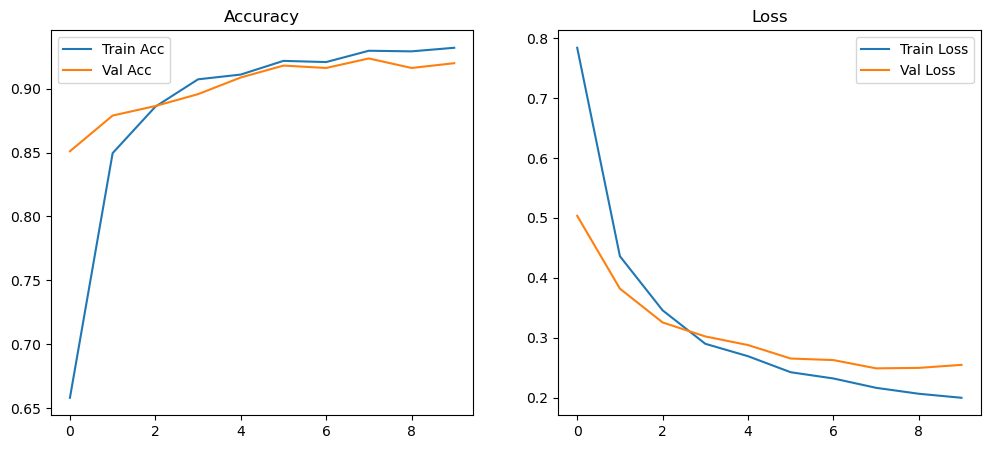

In [39]:
if 'history' in locals():
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
else:
    print("❌ No training history available.")

## 7. Confusion Matrix and Classification Report

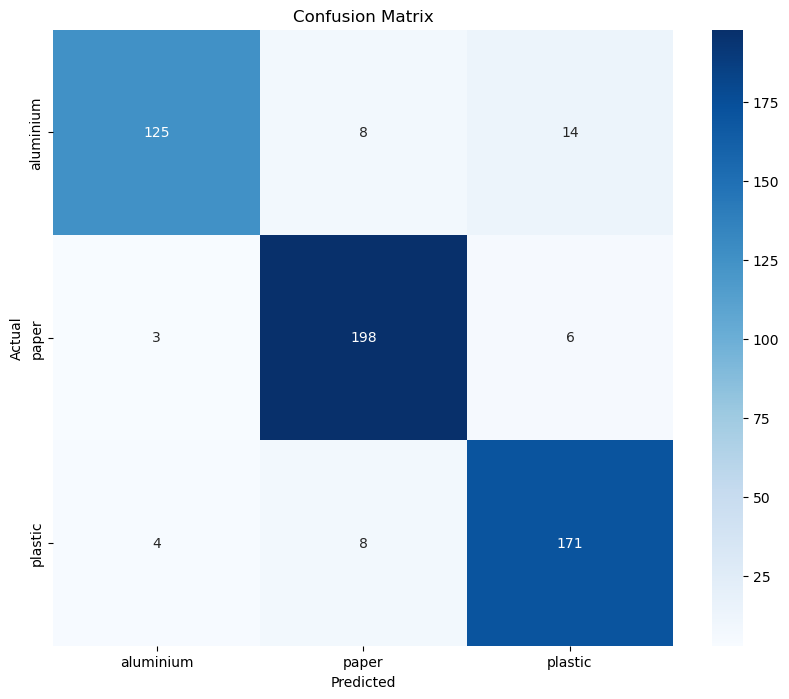


Classification Report:

              precision    recall  f1-score   support

   aluminium       0.95      0.85      0.90       147
       paper       0.93      0.96      0.94       207
     plastic       0.90      0.93      0.91       183

    accuracy                           0.92       537
   macro avg       0.92      0.91      0.92       537
weighted avg       0.92      0.92      0.92       537

✅ Predictions saved to 'predictions_validation.csv'


In [40]:
# Remove duplicate code - Keep only ONE evaluation cell
if 'trained_model' in locals() and 'dataloaders' in locals():
    all_preds = []
    all_labels = []
    all_filenames = []
    
    trained_model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(CONFIG['device'])
            outputs = trained_model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix - Validation Set')
    plt.show()
    
    print("\nClassification Report (Validation Set):\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Save predictions
    import pandas as pd
    df_predictions = pd.DataFrame({
        'true_label': [class_names[label] for label in all_labels],
        'predicted_label': [class_names[pred] for pred in all_preds]
    })
    df_predictions.to_csv('predictions_validation.csv', index=False)
    print("✅ Predictions saved to 'predictions_validation.csv'")
else:
    print("❌ Model not trained or data not loaded.")


🔍 Classifying Images from Dataset Folder

✅ Test dataset loaded successfully!
   Classes: ['aluminium', 'paper', 'plastic']
   Total images: 512
  Batch [1/8] | Accuracy: 0.2656
  Batch [5/8] | Accuracy: 0.9375

📊 TEST RESULTS (Dataset Folder)
Overall Accuracy: 0.6543
Correct Predictions: 335/512



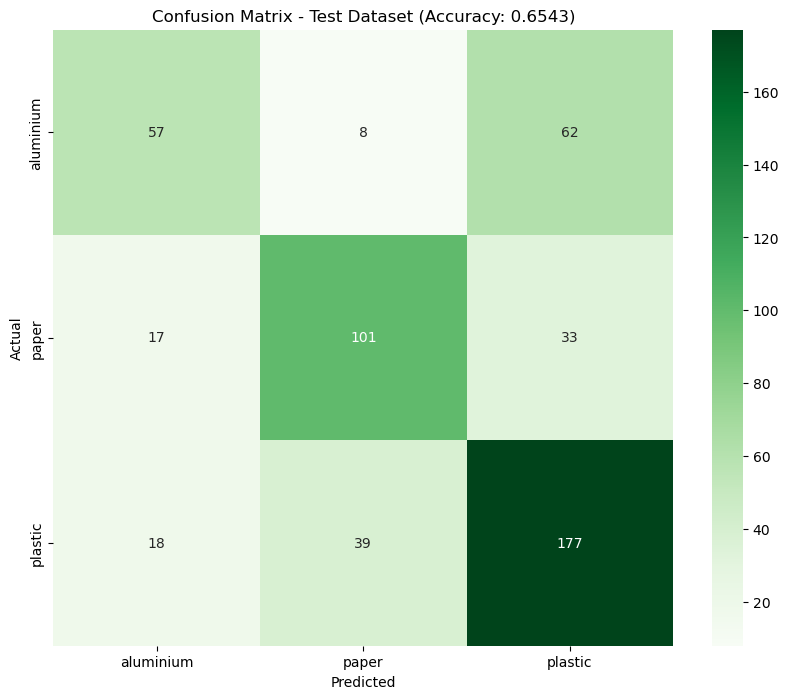

Classification Report (Test Dataset):

              precision    recall  f1-score   support

   aluminium       0.62      0.45      0.52       127
       paper       0.68      0.67      0.68       151
     plastic       0.65      0.76      0.70       234

    accuracy                           0.65       512
   macro avg       0.65      0.62      0.63       512
weighted avg       0.65      0.65      0.65       512


Getting filenames...
✅ Test predictions saved to 'predictions_test_dataset.csv'

📸 Sample Predictions:
   filename true_label predicted_label  correct
0  D100.jpg  aluminium           paper    False
1  D101.jpg  aluminium         plastic    False
2  D102.jpg  aluminium         plastic    False
3  D103.jpg  aluminium         plastic    False
4  D104.jpg  aluminium         plastic    False
5  D105.jpg  aluminium           paper    False
6  D106.jpg  aluminium         plastic    False
7  D107.jpg  aluminium         plastic    False
8  D108.jpg  aluminium         plastic    Fa

In [42]:
# Test on separate "Dataset" folder
print(f"\n{'='*60}")
print(f"🔍 Classifying Images from Dataset Folder")
print(f"{'='*60}\n")

test_data_path = '../Dataset'  # Your separate test dataset

try:
    # Load test dataset
    test_dataset = datasets.ImageFolder(test_data_path, transform=data_transforms['val'])
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=0  # Set to 0 for testing to avoid multiprocessing issues
    )
    
    test_class_names = test_dataset.classes
    print(f"✅ Test dataset loaded successfully!")
    print(f"   Classes: {test_class_names}")
    print(f"   Total images: {len(test_dataset)}")
    
    # Perform inference
    all_test_preds = []
    all_test_labels = []
    all_test_filenames = []
    test_correct = 0
    test_total = 0
    
    trained_model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(CONFIG['device'])
            labels = labels.to(CONFIG['device'])
            
            outputs = trained_model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_test_preds.extend(preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())
            test_correct += torch.sum(preds == labels.data).item()
            test_total += inputs.size(0)
            
            # Print progress
            if (batch_idx + 1) % 5 == 0 or batch_idx == 0:
                batch_accuracy = torch.sum(preds == labels.data).float() / inputs.size(0)
                print(f"  Batch [{batch_idx+1}/{len(test_dataloader)}] | Accuracy: {batch_accuracy:.4f}")
    
    test_accuracy = test_correct / test_total
    
    print(f"\n{'='*60}")
    print(f"📊 TEST RESULTS (Dataset Folder)")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {test_accuracy:.4f}")
    print(f"Correct Predictions: {test_correct}/{test_total}")
    print(f"{'='*60}\n")
    
    # Confusion Matrix for test set
    cm_test = confusion_matrix(all_test_labels, all_test_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Greens')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - Test Dataset (Accuracy: {test_accuracy:.4f})')
    plt.show()
    
    # Classification Report for test set
    print("Classification Report (Test Dataset):\n")
    print(classification_report(all_test_labels, all_test_preds, target_names=class_names))
    
    # Save test predictions with filenames
    print("\nGetting filenames...")
    test_filenames = []
    for path, _ in test_dataset.samples:
        test_filenames.append(os.path.basename(path))
    
    df_test_predictions = pd.DataFrame({
        'filename': test_filenames,
        'true_label': [class_names[label] for label in all_test_labels],
        'predicted_label': [class_names[pred] for pred in all_test_preds],
        'correct': [class_names[label] == class_names[pred] for label, pred in zip(all_test_labels, all_test_preds)]
    })
    df_test_predictions.to_csv('predictions_test_dataset.csv', index=False)
    print("✅ Test predictions saved to 'predictions_test_dataset.csv'")
    
    # Show sample predictions
    print("\n📸 Sample Predictions:")
    print(df_test_predictions.head(10).to_string())
    
except Exception as e:
    print(f"❌ Error loading test dataset: {e}")
    print("Please ensure your test data is in: ../Dataset/class1/, ../Dataset/class2/, etc.")
    import traceback
    traceback.print_exc()

## 9. Detailed Prediction Analysis

In [43]:
# Analyze misclassified images
if 'df_test_predictions' in locals():
    print(f"\n{'='*60}")
    print(f"🔎 Misclassification Analysis")
    print(f"{'='*60}\n")
    
    # Get misclassified predictions
    misclassified = df_test_predictions[df_test_predictions['correct'] == False]
    
    print(f"Total Misclassified: {len(misclassified)}/{len(df_test_predictions)}")
    print(f"Misclassification Rate: {len(misclassified)/len(df_test_predictions)*100:.2f}%\n")
    
    if len(misclassified) > 0:
        print("Top Misclassifications:")
        print(misclassified[['filename', 'true_label', 'predicted_label']].head(10).to_string())
    else:
        print("✅ Perfect! No misclassifications!")
    
    # Accuracy per class
    print(f"\n{'='*60}")
    print(f"📈 Per-Class Accuracy")
    print(f"{'='*60}\n")
    
    for class_name in class_names:
        class_mask = df_test_predictions['true_label'] == class_name
        class_correct = (df_test_predictions[class_mask]['correct'] == True).sum()
        class_total = class_mask.sum()
        class_acc = class_correct / class_total if class_total > 0 else 0
        print(f"{class_name:15} | {class_correct:3}/{class_total:3} | Accuracy: {class_acc:.4f}")
else:
    print("❌ Test predictions not available yet. Run the previous cell first.")


🔎 Misclassification Analysis

Total Misclassified: 177/512
Misclassification Rate: 34.57%

Top Misclassifications:
   filename true_label predicted_label
0  D100.jpg  aluminium           paper
1  D101.jpg  aluminium         plastic
2  D102.jpg  aluminium         plastic
3  D103.jpg  aluminium         plastic
4  D104.jpg  aluminium         plastic
5  D105.jpg  aluminium           paper
6  D106.jpg  aluminium         plastic
7  D107.jpg  aluminium         plastic
8  D108.jpg  aluminium         plastic
9  D109.jpg  aluminium         plastic

📈 Per-Class Accuracy

aluminium       |  57/127 | Accuracy: 0.4488
paper           | 101/151 | Accuracy: 0.6689
plastic         | 177/234 | Accuracy: 0.7564
